In [ ]:
from pycaret.classification import ClassificationExperiment
from sklearn.metrics import log_loss, accuracy_score, roc_auc_score, recall_score, precision_score, f1_score, cohen_kappa_score, matthews_corrcoef
from mlflow.models.signature import infer_signature
import mlflow
import pandas as pd

mlflow.set_tracking_uri("http://127.0.0.1:5500")
base_train = catalog.load('base_train')
base_test = catalog.load('base_test')

# base_train = pd.read_parquet('/Users/luiz/Study/eng-ml/kobe-bryant/data/processed/base_train.parquet')
# base_test = pd.read_parquet('/Users/luiz/Study/eng-ml/kobe-bryant/data/processed/base_test.parquet')

In [ ]:
exp = ClassificationExperiment()

exp.setup(
    data=base_train,
    test_data=base_test,
    target='shot_made_flag',
    session_id=42,
    normalize=True,
    normalize_method='robust',
    log_experiment=True,
    experiment_name='kobe'
)

# Treinar o modelo de arvore de decisao
dt_model = exp.create_model('dt')
dt_tuned_model = exp.tune_model(dt_model, n_iter=100, optimize='F1')

,Description,Value
0,Session id,42
1,Target,shot_made_flag
2,Target type,Binary
3,Original data shape,"(20285, 7)"
4,Transformed data shape,"(20285, 7)"
5,Transformed train set shape,"(16228, 7)"
6,Transformed test set shape,"(4057, 7)"
7,Numeric features,6
8,Preprocess,True
9,Imputation type,simple


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.5287,0.5097,0.5711,0.5051,0.5361,0.0607,0.0612
1,0.5293,0.5041,0.6021,0.5054,0.5495,0.0644,0.0655
2,0.5416,0.5227,0.5884,0.5176,0.5507,0.0867,0.0874
3,0.5373,0.5203,0.6284,0.5126,0.5646,0.0816,0.0835
4,0.5588,0.5355,0.6116,0.5332,0.5697,0.1215,0.1227
5,0.5348,0.5240,0.5703,0.5116,0.5394,0.0723,0.0728
6,0.5200,0.5066,0.5871,0.4978,0.5388,0.0455,0.0461
7,0.5182,0.4966,0.5690,0.4961,0.5300,0.0405,0.0409
8,0.5247,0.4974,0.5788,0.5017,0.5375,0.0537,0.0543


2025/04/03 11:37:52 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.5607,0.5661,0.5116,0.5417,0.5262,0.1173,0.1175
1,0.5656,0.5642,0.5633,0.5430,0.5529,0.1308,0.1309
2,0.5829,0.5785,0.5600,0.5636,0.5618,0.1638,0.1638
3,0.5533,0.5537,0.5213,0.5330,0.5271,0.1039,0.1040
4,0.5773,0.5728,0.5110,0.5633,0.5359,0.1495,0.1501
5,0.5354,0.5342,0.4723,0.5148,0.4926,0.0657,0.0659
6,0.5268,0.5284,0.4645,0.5049,0.4839,0.0484,0.0486
7,0.5638,0.5652,0.5342,0.5440,0.5391,0.1251,0.1251
8,0.5604,0.5494,0.5271,0.5404,0.5337,0.1181,0.1181


Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


2025/04/03 11:37:55 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


In [7]:
# Avaliar o modelo no conjunto de teste
predictions = exp.predict_model(dt_tuned_model, data=base_test)

# Definir um exemplo de entrada para a assinatura do modelo
input_example = base_test.drop(columns=['shot_made_flag']).head()
signature = infer_signature(input_example, predictions[['prediction_label']])

# Calcular métricas manualmente
y_true = base_test['shot_made_flag']
y_pred = predictions['prediction_label']
y_pred_proba = predictions['prediction_score']  # Probabilidades para log_loss

metrics = {
    'accuracy': accuracy_score(y_true, y_pred),
    'precision': precision_score(y_true, y_pred),
    'recall': recall_score(y_true, y_pred),
    'f1': f1_score(y_true, y_pred),
    'log_loss': log_loss(y_true, y_pred_proba)
}

metrics

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Decision Tree Classifier,0.5467,0.5234,0.5994,0.5220,0.5580,0.0973,0.0983


{'accuracy': 0.5467093911757456,
 'precision': 0.5220323741007195,
 'recall': 0.5993804852865255,
 'f1': 0.5580389329488104,
 'log_loss': 16.426797492649104}

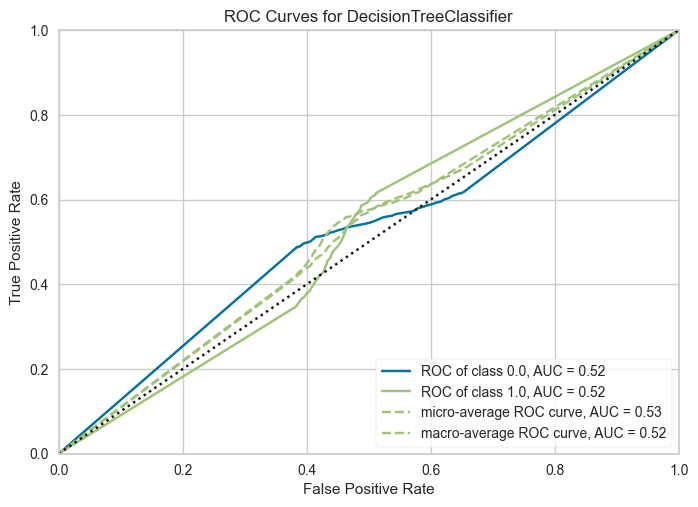

In [8]:
ret = exp.plot_model(dt_tuned_model, plot='auc')

In [ ]:
# exp.save_model(dt_model, model_name="dt_model")

In [ ]:
Logar métricas calculadas
mlflow.sklearn.log_model(
    sk_model=dt_model,
    artifact_path='dt_model',
    signature=signature,
    input_example=input_example
)
mlflow.log_metrics(metrics)

In [ ]:
exp.evaluate_model(dt_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…